In [9]:
import pandas as pd
import numpy as np
import glob, subprocess, os, tqdm, copy, re 
import xml.etree.ElementTree as ET
from PIL import ImageFont
from matplotlib import pyplot as plt 

In [10]:
cd /home/andre/Projects/teaching/alfabeto

/home/andre/Projects/teaching/alfabeto


In [11]:
cardw, cardh = 70.5, 48.9 # card size 

def textbox(text, size=16, fontfile="FreeSerif.ttf", stroke_width=0.25):
    font = ImageFont.truetype(fontfile, size=size)  
    w, h = font.getsize(text, stroke_width=stroke_width)
    return [w, h]

def optimize_fontsize(text, maxw, maxh, default_size=17):
    # generate sample data to interpolate (4 points)
    # text area width  vs font size    
    # text area height vs font size
    pts = np.array([ [ size ] + textbox(text, size) for size in np.arange(default_size-8, default_size+8, 3) ])     
    gap = 0.15 # 15% of gap 
    w_interp = np.poly1d(np.polyfit(pts[:, 1], pts[:, 0], 1)) # (width, font_size) interpolator 
    fw = w_interp(int(cardw*(1-gap))) # get font size for 90% height 
    h_interp = np.poly1d(np.polyfit(pts[:, 2], pts[:, 0], 1)) # (height, font_size) interpolator 
    fh = h_interp(int(cardh*(1-gap))) # get font size for 90% width 
    #print(f"{text} w:{fw:.1f}, h:{fh:.1f}")
    return round(min(fw, fh),2)

def make_card_svg(etree_master, 
            card_words, 
            filename, 
            font_family='FreeSerif', 
            upper=True,
            lower=True):
    def text_set_style(etext, font_family):       
        fontsize = optimize_fontsize(etext.text, cardw, cardh) if etext.text else 17 # avoiding '' strings     
        # https://stackoverflow.com/q/2973436/1207193 positive look behind           
        etext.set('style', re.sub("(?<=font-size:)[\d\.]+", str(fontsize), etext.attrib['style'])) # change font-size 
        etext.set('style', re.sub("(?<=font-family:)\w+", font_family, etext.attrib['style'])) # change font-family 
        #font-family:FreeSerif    
    nwords = np.array(card_words[:16])
    if upper: # first page UPPER case    
        etree = copy.deepcopy(etree_master)
        etexts = etree.findall(".//{*}text")            
        for i, etext in enumerate(etexts): 
            etext.text = nwords[i].upper() # upper case only    
            text_set_style(etext, font_family)        
        etree.write(filename+".svg", encoding="UTF-8")       
    if lower: # second page LOWER case - verse 
        etree = copy.deepcopy(etree_master) 
        etexts = etree.findall(".//{*}text")
        nwords = nwords.reshape((4,4)) # create ndarray of 4x4 columns    
        nwords = np.apply_along_axis(lambda x: x[::-1], -1, nwords) # invert rows 
        nwords = nwords.flatten()
        for i, etext in enumerate(etexts):        
            etext.text = nwords[i].lower() # lower case only
            text_set_style(etext, font_family)
        etree.write(filename+"v.svg", encoding="UTF-8")   

#### 1. Read excel and prepare content for printing 

#### 2. Create as many svg files as needed names are card1, card1v, card2, card2v ... 

A4 landscape

#### 3. Then convert svgs to pdf and merge them 

In [12]:
cards = pd.read_excel('data/cards-unico.xlsx', header=0)
cards = cards.convert_dtypes()
cards.fillna('', inplace=True)
cards

,coluna1,coluna2,coluna3,coluna4,grupo,tabela-src,status
0,a,e,i,o,vogais,-,done
1,u,,,,vogais,-,done
2,ba,ca,da,fa,silabário,-,done
3,be,ce,de,fe,silabário,-,done
4,bi,ci,di,fi,silabário,-,done
...,...,...,...,...,...,...,...
247,PLU,TRU,TRUTA,TREZE,"palavras tl, tr",aula23,-
248,DRA,DRE,DRI,DRO,palavras dr,aula23,-
249,DRAGÃO,DRENO,LADRILHO,DRU,palavras dr,aula23,-
250,QUADRUPEDE,DROMEDÁRIO,PADRÃO,QUADRO,palavras dr,aula23,-


In [ ]:
def make_cards(dfcardwords, filename, font='FreeSerif', verbose=True, upper=True, lower=True):
    data = dfcardwords.iloc[:, :4]
    data = data.values.flatten()
    # complete page to have 16 elements
    if len(data)%16 != 0:
        data = np.append(data, ['']*(16-len(data)%16))
        data[data == 'nan'] = ''
    data = data.reshape((-1, 16)) # see number many pages
    if verbose:
        print(data[:5])
        print("number of pages: ", data.shape[0])
    # parse xml and get svg text tag to replace text
    etree_master = ET.parse('master/word_cards_main.svg') # original and reference card file to replace text  
    # generate as many svg files as needed names are card1, card1v, card2, card2v ... 
    for i, pg_data in tqdm.tqdm(enumerate(data), total=len(data)):
        make_card_svg(etree_master, pg_data, 'card'+str(i+1), font_family=font, upper=upper, lower=lower)
    for svgfile in tqdm.tqdm(glob.glob("card*.svg")):
        name = svgfile.replace('.svg', '')
        ok = subprocess.run(f"/usr/bin/inkscape --export-filename={name}.pdf {name}.svg".split(' '))
        if not isinstance(ok, subprocess.CompletedProcess):
            print("Erro!")
    # shell=True to use wildcards * and dont need to .split(' ')
    subprocess.run(f"/usr/bin/pdftk card*.pdf cat output {filename}.pdf", shell=True) 
    subprocess.run(f"rm card*.pdf card*.svg", shell=True) # clean up svgs pdfs

font = 'MamaeQueNosFaz'
font = 'FreeSerif'
cardsgby = cards.groupby(cards.grupo)
grupos = list(cardsgby.groups.keys()) # todos os cards nomes
#grupos = ['silabário'] # choosing only one
# #re.sub(r'[,\- ]+', '_', 'palavras lh, cr')
for grupo in tqdm.tqdm(grupos):
    fname = re.sub(r'[,\- ]+', '_', grupo.lower()) # making acceptable file names       
    make_cards(cardsgby.get_group(grupo), fname, font=font, upper=True, verbose=True) 
    subprocess.run(f"mv {fname}.pdf prontos", shell=True)

Playing with font with font size pixel and glyph sizes

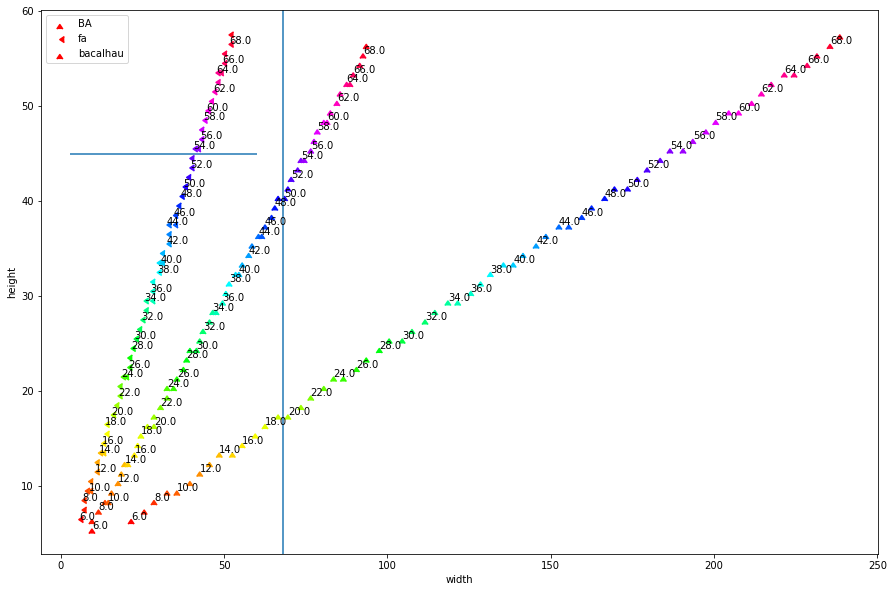

In [59]:
#%matplotlib widget
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)#, projection='3d')

for word in ['BA', 'fa', 'bacalhau']: # pixels equivalent to mm in my case
    vs = [] 
    for size in np.arange(6, 70, 1):
        w, h = textbox(word, int(size))
        vs.append([size, w, h])
        #print('w, h: ', w, h, ' for word: ', word)
    vs = np.array(vs)
    ax.scatter(vs[:, 1], vs[:, 2], c=vs[:, 0], marker=np.random.randint(0, 10), label=word, cmap='hsv')
    for i in range(0, len(vs), 2):
        ax.annotate(f"{vs[i, 0]}", (vs[i, 1], vs[i, 2]))
ax.set_xlabel('width')
ax.set_ylabel('height')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.vlines(cardw, *xlim)
ax.hlines(cardh, *ylim)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()